# Installation and Imports

In [18]:
# Check the GPU
!nvidia-smi

Tue Jul 14 22:35:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    32W / 250W |   7715MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [50]:
import os.path

from keras import Model, optimizers
from keras.applications import xception
from keras.layers import GlobalAveragePooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

## Configuration Parameters

In [20]:
img_width = 197
img_height = 197

batch_size = 120

base_path = '/content/drive/My Drive/Colab_Notebooks/data/monkey/'

train_path = base_path + 'training-data/training'
validation_path = base_path + 'validation-data/validation'

nb_classes = 10

## Preparing the dataset

In [21]:
# Counts the number of training and testing samples in the directories
training_samples = sum([len(files) for r, d, files in os.walk(train_path)])
validation_samples = sum([len(files) for r, d, files in os.walk(validation_path)])

print("Number of samples in Training dataset:", training_samples)
print("Number of samples in Validation dataset:", validation_samples)

Number of samples in Training dataset: 1098
Number of samples in Validation dataset: 272


## Data augmentation

In [22]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.2,
    rescale=1.0 / 255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
)

validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


# Model

## Main functions

In [23]:
# Adds new top to base model
def add_top(base):
    x = base.output

    # Global averaging pool layer
    x = GlobalAveragePooling2D()(x)

    # Regular densely connected layer
    x = Dense(512, activation='relu')(x)

    # Output layer
    predictions = Dense(nb_classes, activation='softmax')(x)

    return Model(input=base.input, output=predictions)

In [24]:
# Sets up model for transfer learning
def setup_model(model, base):
    # Freeze the un-trainable layers of the model base
    for layer in base.layers:
        layer.trainable = False

    model.compile(
        loss='categorical_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy']
    )

## Importing the pre-trained model

In [25]:
# Import the Xception model to use as the base for our model
xception_base = xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(img_width, img_height, 3)
)

In [41]:
xception_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 98, 98, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 98, 98, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 98, 98, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

## Transfer learning

In [26]:
model = add_top(xception_base)
setup_model(model, xception_base)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


# Training

## Parameters

In [27]:
epochs = 10

## Train the new layers

In [28]:
# Train our new top layer
history1 = model.fit_generator(
    train_generator,
    steps_per_epoch = training_samples // batch_size,
    epochs = epochs,
    validation_data= validation_generator,
    validation_steps = validation_samples // batch_size,
    verbose = 1,
)

Epoch 1/10
1/9 [==>...........................] - ETA: 1:08 - loss: 2.3632 - accuracy: 0.0556

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


2/9 [=====>........................] - ETA: 4:05 - loss: 3.0388 - accuracy: 0.1087

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


3/9 [=========>....................] - ETA: 4:26 - loss: 3.0460 - accuracy: 0.1124

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 5 could not be retrieved. It could be because a worker has died.
  UserWarning)


4/9 [============>.................] - ETA: 4:01 - loss: 2.8772 - accuracy: 0.1720

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 7 could not be retrieved. It could be because a worker has died.
  UserWarning)


5/9 [===============>..............] - ETA: 3:21 - loss: 2.7054 - accuracy: 0.2068

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)


6/9 [===================>..........] - ETA: 2:34 - loss: 2.6037 - accuracy: 0.2395

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)


7/9 [======================>.......] - ETA: 1:43 - loss: 2.5172 - accuracy: 0.2669

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 6 could not be retrieved. It could be because a worker has died.
  UserWarning)


8/9 [=========================>....] - ETA: 52s - loss: 2.3981 - accuracy: 0.3077 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)


9/9 [==============================] - 478s 53s/step - loss: 2.2934 - accuracy: 0.3456 - val_loss: 0.6453 - val_accuracy: 0.7958
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 8 could not be retrieved. It could be because a worker has died.
  UserWarning)


9/9 [==============================] - 85s 9s/step - loss: 1.1737 - accuracy: 0.6871 - val_loss: 0.7124 - val_accuracy: 0.8224
Epoch 3/10
9/9 [==============================] - 32s 4s/step - loss: 1.0188 - accuracy: 0.7342 - val_loss: 1.0685 - val_accuracy: 0.8224
Epoch 4/10
9/9 [==============================] - 36s 4s/step - loss: 0.8137 - accuracy: 0.7638 - val_loss: 0.4969 - val_accuracy: 0.8292
Epoch 5/10
9/9 [==============================] - 36s 4s/step - loss: 0.5928 - accuracy: 0.8303 - val_loss: 0.7785 - val_accuracy: 0.7961
Epoch 6/10
9/9 [==============================] - 33s 4s/step - loss: 0.5837 - accuracy: 0.8315 - val_loss: 1.1834 - val_accuracy: 0.9276
Epoch 7/10
9/9 [==============================] - 33s 4s/step - loss: 0.6188 - accuracy: 0.8196 - val_loss: 1.1200 - val_accuracy: 0.7833
Epoch 8/10
9/9 [==============================] - 40s 4s/step - loss: 0.5938 - accuracy: 0.8287 - val_loss: 0.4237 - val_accuracy: 0.8947
Epoch 9/10
9/9 [=============================

# Fine Tune

## Main functions

In [29]:
# Setup model for fine tuning
def setup_model(model, trainable):
    # Freeze the un-trainable layers of the model base
    for layer in model.layers[:(len(model.layers) - trainable)]:
        layer.trainable = False

    for layer in model.layers[(len(model.layers) - trainable):]:
        layer.trainable = True

    model.compile(
        loss='categorical_crossentropy',
        # Slower training rate for fine-tuning
        optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
        metrics=['accuracy']
    )

## Parameters

In [30]:
epochs_ft = 10

## Training

In [31]:
# Setup model to retrain our top layer plus block 13 and 14 of Xception
setup_model(model, 19)

In [33]:
# Fine-tune the model
history2 = model.fit_generator(
    train_generator,
    steps_per_epoch = training_samples // batch_size,
    epochs = epochs_ft,
    validation_data = validation_generator,
    validation_steps = validation_samples // batch_size,
    verbose=1,
)

Epoch 1/10
9/9 [==============================] - 40s 4s/step - loss: 0.3811 - accuracy: 0.8814 - val_loss: 0.8125 - val_accuracy: 0.8708
Epoch 2/10
9/9 [==============================] - 37s 4s/step - loss: 0.3543 - accuracy: 0.8981 - val_loss: 0.3323 - val_accuracy: 0.9342
Epoch 3/10
9/9 [==============================] - 29s 3s/step - loss: 0.3748 - accuracy: 0.8973 - val_loss: 1.0447 - val_accuracy: 0.8882
Epoch 4/10
9/9 [==============================] - 37s 4s/step - loss: 0.3270 - accuracy: 0.9167 - val_loss: 0.4141 - val_accuracy: 0.8917
Epoch 5/10
9/9 [==============================] - 32s 4s/step - loss: 0.3697 - accuracy: 0.8973 - val_loss: 0.4518 - val_accuracy: 0.9276
Epoch 6/10
9/9 [==============================] - 33s 4s/step - loss: 0.3464 - accuracy: 0.9028 - val_loss: 0.6359 - val_accuracy: 0.9013
Epoch 7/10
9/9 [==============================] - 34s 4s/step - loss: 0.3467 - accuracy: 0.9059 - val_loss: 0.4221 - val_accuracy: 0.9167
Epoch 8/10
9/9 [==================

# Diagrams

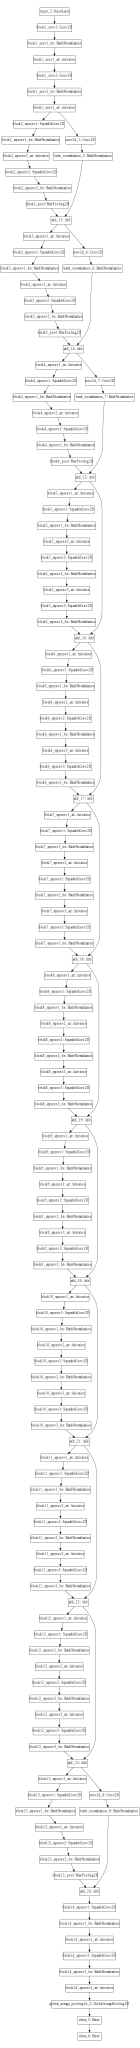

In [48]:
SVG(model_to_dot(model, show_shapes = False, show_layer_names=True, rankdir='HB', dpi = 72).create(prog='dot', format='svg'))

In [40]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 98, 98, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 98, 98, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 98, 98, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

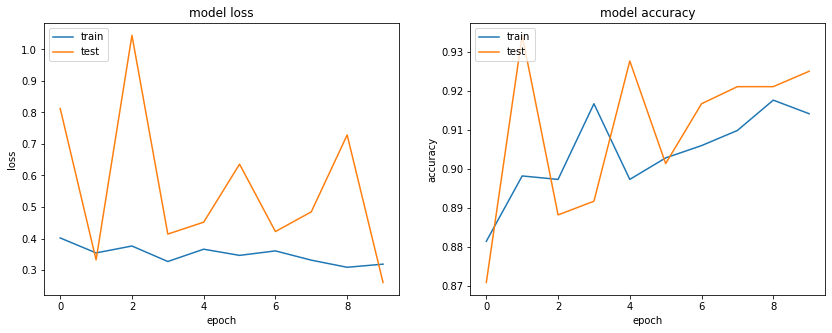

In [51]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))

history = history2

ax[0].plot(history.history["loss"])
ax[0].plot(history.history["val_loss"])
ax[0].set_title("model loss")
ax[0].set_ylabel("loss")
ax[0].set_xlabel("epoch")
ax[0].legend(["train", "test"], loc="upper left")

ax[1].plot(history.history["accuracy"])
ax[1].plot(history.history["val_accuracy"])
ax[1].set_title("model accuracy")
ax[1].set_ylabel("accuracy")
ax[1].set_xlabel("epoch")
ax[1].legend(["train", "test"], loc="upper left")

plt.show()